In [3]:
# import json
# from decimal import Decimal, InvalidOperation

# # Custom JSON decoder function to convert strings back to Decimal
# def decimal_decoder(obj):
#     for key, value in obj.items():
#         if isinstance(value, str):  # Ensure the value is a string
#             try:
#                 # Attempt to convert strings that look like Decimals back to Decimal objects
#                 obj[key] = Decimal(value)
#             except InvalidOperation:
#                 pass  # Skip conversion if the value cannot be converted to Decimal
#     return obj

# # Read the list of dictionaries back from the JSON file
# with open('allpick_matches_2000.json', 'r') as file:
#     objs = json.load(file, object_hook=decimal_decoder)

In [4]:
from decimal import Decimal
import json
from decimal import InvalidOperation

objs = []
root = '/Users/rivers/Desktop/nice datasets/MOBA/'
data_root = root+'matches/'
save_root = root+'Topics/Bursty/intermediate/'
graph_root = root+'Topics/Bursty/results/'
game_mode = -1

mode_dict = {-1: 'captainrank', 22: 'rank',1:'allpick',5:'allrandom'}

# Custom JSON decoder function to convert strings back to Decimal
def decimal_decoder(obj):
    for key, value in obj.items():
        if isinstance(value, str):  # Ensure the value is a string
            try:
                # Attempt to convert strings that look like Decimals back to Decimal objects
                obj[key] = Decimal(value)
            except InvalidOperation:
                pass  # Skip conversion if the value cannot be converted to Decimal
    return obj

# Read the list of dictionaries back from the JSON file
with open(data_root+'%s_matches_2000.json'%(mode_dict[game_mode]), 'r') as file:
    objs = json.load(file, object_hook=decimal_decoder)

In [5]:
def calculate_differences(int_list):
    # Ensure the list has at least 2 elements
    if len(int_list) < 2:
        raise ValueError("The list must contain at least 2 elements.")

    # Calculate the differences between consecutive elements
    differences = [int_list[i+1] - int_list[i] for i in range(len(int_list) - 1)]
    
    return differences

def chats_of(slot,chat):
    t = []
    l = []
    for chat_line in chat:
        #print(chat_line)
        if 'slot' in list(chat_line.keys()):
            if chat_line['slot'] == slot:
                t.append(chat_line['time'])
                l.append(len(str(chat_line['key'])))
    if len(t) > 1:
        t_diff = calculate_differences(t)
        t_diff.insert(0,0)
    
        return l, t_diff
    else:
        return [],[]


In [7]:
import numpy as np
modes = list(mode_dict.keys())
slots = list(range(10))

team_t, team_l, ind_t, ind_l, pois_ts, lambs= {}, {}, {}, {}, {}, {}

for mode in modes:
    with open(data_root+'%s_matches_2000.json'%(mode_dict[mode]), 'r') as file:

        objs = json.load(file, object_hook=decimal_decoder)

        
    team_t_sample, team_l_sample, ind_t_sample, ind_l_sample, pois_t = [], [], [], [], []
    for obj in objs:
        if (mode == 2 and obj['lobby_type'] == 7) or mode != 2:
            time = []
            if len(obj['chat']) > 1:
                for chat_line in obj['chat']:
                    time.append(chat_line['time'])
                    
                    team_l_sample.append(len(str(chat_line['key'])))
                
                diff = calculate_differences(time)
                diff.insert(0,0)
                team_t_sample += diff
            
            for slot in slots:
                l, t_diff = chats_of(slot, obj['chat'])
                ind_t_sample += t_diff
                ind_l_sample += l
        if len(obj['chat'])>0 and obj['chat'][0]['time']>0:
            ini_t = obj['chat'][0]['time']
            pois_t.append(ini_t)
    pois_ts[mode] = pois_t
    lambs[mode] = 1/np.mean(pois_t)
    team_t[mode], team_l[mode], ind_l[mode], ind_t[mode] = team_t_sample, team_l_sample, ind_l_sample, ind_t_sample


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

save = False

def add1(lst):
    return [x + 1 for x in lst]

def empirical_ccdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    cdf = np.cumsum(counts[::-1])[::-1]  # Reverse cumulative sum
    ccdf = cdf / cdf[0]  # Normalize to 1
    return bin_edges[1:], ccdf

def empirical_pdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    pdf = counts / np.sum(counts)  # Normalize to sum to 1
    return bin_edges[1:], pdf

def power_law(x, gamma):
    return x ** -gamma

def exponential(x, A, beta):
    return A * np.exp(-beta * x)
    
def safe_exponential(x, A, beta):
    x = x / np.max(x)  # Rescale x
    return A * np.exp(-beta * x)

def compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K):
    # Compute model CCDF
    model_ccdf = np.piecewise(
        x_vals,
        [x_vals < tau_0 - t, x_vals > tau_0 + t],
        [lambda x: power_law(x, gamma), lambda x: exponential(x, *popt_exp)]
    )
    
    # Ensure numerical stability
    ccdf_vals = np.where(ccdf_vals <= 0, 1e-10, ccdf_vals)
    model_ccdf = np.where(model_ccdf <= 0, 1e-10, model_ccdf)
    
    # Select K bins for error calculation

    num,denom=0,0
    # Compute error function based on the given formula
    for k in range(1,K+1):
        indices = np.linspace(0, len(x_vals) - 1, k, dtype=int)
        ccdf_vals_k = ccdf_vals[indices]
        model_ccdf_k = model_ccdf[indices]
        # print(len(ccdf_vals_k),ccdf_vals_k)
        # print(len(model_ccdf_k),model_ccdf_k)
        print(model_ccdf)
        num += np.sum(np.abs(np.log(model_ccdf_k) - np.log(ccdf_vals_k)))
        denom += np.sum(np.abs(np.log(model_ccdf_k) + np.log(ccdf_vals_k)))
    
    # Avoid division by zero
    if denom == 0:
        return np.nan  # Assign NaN if denominator is zero
    
    error = 2 * num / denom
    return error

def fit_bimodal(data, tau_0, tau_1, t, K):
    data = np.array(data)  # Ensure data is a NumPy array

    # Compute empirical CCDF
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)), K)
    #print(bins)
    x_vals, ccdf_vals = empirical_ccdf(data, bins)

    # Fit power-law
    pl_x = x_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    pl_y = ccdf_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    popt_pl, _ = curve_fit(lambda x, gamma: power_law(x, gamma), pl_x, pl_y)#, p0=[1.5])

    # Fit exponential
    exp_x = x_vals[x_vals > tau_0 + t]
    exp_y = ccdf_vals[x_vals > tau_0 + t]
    
    if len(exp_x) > 0 and len(exp_y) > 0:
        popt_exp, _ = curve_fit(lambda x, A, beta: exponential(x, A, beta), exp_x, exp_y)#, p0=[1, 0.01])
    else:
        print("Warning: No valid exponential data. Adjust τ₀ or t.")
        popt_exp = [np.nan, np.nan]  # Placeholder for failed fit
    
    return x_vals, ccdf_vals, popt_pl[0], popt_exp  # Ensure popt_exp is returned

def plot_ccdf(data, x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, mode):
    plt.figure(figsize=(8,6))
    
    # Empirical CCDF
    plt.scatter(x_vals, ccdf_vals, label='Empirical CCDF', color='black', alpha=0.6)
    
    # Fitted power-law
    pl_x = x_vals[x_vals < tau_0 - t]
    plt.plot(pl_x, power_law(pl_x, gamma), linestyle='dashed', color='blue', label=f'Power-law Fit (γ={gamma:.4f})')
    
    # Fitted exponential
    exp_x = x_vals[(x_vals > tau_0 + t) & (x_vals <= 4000)]
    print(f"exp_x range: min={np.min(exp_x)}, max={np.max(exp_x)}")
    # print(f"exp_y range: min={np.min(exp_y)}, max={np.max(exp_y)}")
    if not np.isnan(popt_exp[0]):  # Check if fitting was successful
        plt.plot(exp_x, exponential(exp_x, *popt_exp), linestyle='dashed', color='red', label=f'Exponential Fit (β={popt_exp[1]:.4f})')
    print('beta: ', popt_exp[1])
    beta = popt_exp[1]
    print(f"Fitted A: {popt_exp[0]}, Fitted beta: {popt_exp[1]}")
    print('p1 =',(beta/lambs[mode])-1)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('τ')
    plt.ylabel('CCDF')
    plt.legend()
    plt.title('Bimodal fit: '+ mode_dict[mode])
    if save:
        plt.savefig(graph_root+'/bimodal/fitted_%s.pdf'%str(mode_dict[mode]))
    plt.show()

# def compute_error(k):



def find_best_tau0(data, tau_1, t, K):
    tau0_values = np.linspace(400, 1400, 20)
    e_lst = []
    
    # for tau_0 in tau0_values:
    #     x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)
    #     error = compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K)
    #     e_lst.append(error)
    
    
    for tau_0 in tau0_values:
        e, num, denom = 0, 0, 0
        
        for k in range(20, K+1):
            x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)
            model_ccdf = np.piecewise(
                x_vals,
                [x_vals < tau_0 - t, (x_vals > tau_0 + t) & (x_vals <= 3000)],
                [lambda x: power_law(x, gamma), lambda x: exponential(x, *popt_exp)]
            )
            indices = np.linspace(0, len(x_vals) - 1, k, dtype=int)
            ccdf_vals_k = ccdf_vals[indices]
            model_ccdf_k = model_ccdf[indices]
            
            num += np.sum(np.abs(np.log(model_ccdf_k) - np.log(ccdf_vals_k)))
            denom += np.sum(np.abs(np.log(model_ccdf_k) + np.log(ccdf_vals_k)))
            e = 2 * num/denom
            # print(np.abs(np.log(model_ccdf) - np.log(ccdf_vals)))
    e_lst.append(e)
    best_tau0 = tau0_values[np.nanargmin(e_lst)]  # Find tau_0 with the minimum error
    return best_tau0, tau0_values, e_lst

import numpy as np


# def find_best_tau0(data, tau_1, t, K):
#     tau0_values = np.linspace(400, 1400, 20)
#     e_lst = []
    
#     for tau_0 in tau0_values:
#         e, num, denom = 0, 0, 0
#         valid_k = False  # Track if any valid k exists
        
#         for k in range(20, K+1):
#             try:
#                 x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)
                
#                 if len(x_vals) == 0 or len(ccdf_vals) == 0:
#                     continue  # Skip if no valid data
                
#                 # Compute the model CCDF
#                 model_ccdf = np.piecewise(
#                     x_vals,
#                     [x_vals < tau_0 - t, x_vals > tau_0 + t],
#                     [lambda x: power_law(x, gamma), lambda x: exponential(x, *popt_exp)]
#                 )
                
#                 # Select `k` evenly spaced indices
#                 indices = np.linspace(0, len(x_vals) - 1, k, dtype=int)
#                 ccdf_vals_k = ccdf_vals[indices]
#                 model_ccdf_k = model_ccdf[indices]
#                 print(model_ccdf)
#                 print(model_ccdf_k)
                
#                 # Avoid log(0) errors
#                 mask = (model_ccdf_k > 0) & (ccdf_vals_k > 0)
#                 if np.sum(mask) == 0:
#                     continue  # Skip if no valid values
                
#                 num += np.sum(np.abs(np.log(model_ccdf_k[mask]) - np.log(ccdf_vals_k[mask])))
#                 denom += np.sum(np.abs(np.log(model_ccdf_k[mask]) + np.log(ccdf_vals_k[mask])))
#                 valid_k = True  # At least one valid k
        
#             except Exception as ex:
#                 print(f"Skipping tau_0={tau_0}, k={k} due to error: {ex}")
#                 continue  # Skip problematic values
        
#         # Compute final error
#         if valid_k and denom > 0:
#             e = 2 * num / denom
#         else:
#             e = np.nan  # Mark invalid tau_0 values
        
#         e_lst.append(e)

#     # Handle all-NaN case
#     if np.all(np.isnan(e_lst)):
#         print("Warning: No valid tau_0 values found. Returning default.")
#         return np.nan, tau0_values, e_lst  # Return NaN instead of crashing
    
#     best_tau0 = tau0_values[np.nanargmin(e_lst)]  # Avoid NaN issues
#     return best_tau0, tau0_values, e_lst

# Example Usage (Replace with your actual data)
for mode in modes:
    print('current mode: ', mode_dict[mode])
    t = 20
    K = 40
    tau_1 = 7
    data = np.array(add1(team_t[mode]))
    best_tau0,_,_ = find_best_tau0(data,tau_1,t,K)
    tau_0 = best_tau0

      # Ensure numeric conversion
    best_tau0, tau0_values, e_lst = find_best_tau0(data, tau_1, t, K)
    print('best tau_0 = ', best_tau0)


    # Plot error vs tau_0
    plt.figure(figsize=(8, 6))
    plt.plot(tau0_values, e_lst, marker='o', linestyle='-')
    plt.xlabel(r'\tau_0')
    plt.ylabel('Fit Error')
    plt.title('Fit Error vs. \tau_0')
    plt.grid(True)
    if save:
        plt.savefig(graph_root+'/bimodal/E_tau_%s.pdf'%str(mode_dict[mode]))
    plt.show()
    # print(e_lst)
    # print(tau_0)
    x_vals, ccdf_vals, gamma, beta = fit_bimodal(data, tau_0, tau_1, t, K)
    error = compute_error(x_vals, ccdf_vals, gamma, beta, tau_0, t, K)
    plot_ccdf(data, x_vals, ccdf_vals, gamma, beta, tau_0, t,mode)

    print(f'Best Fit Error: {error:.4f}')

current mode:  captainrank


/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_74085/2487286624.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_exp, _ = curve_fit(lambda x, A, beta: exponential(x, A, beta), exp_x, exp_y)#, p0=[1, 0.01])
/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_74085/2487286624.py:148: RuntimeWarning: divide by zero encountered in log
  num += np.sum(np.abs(np.log(model_ccdf_k) - np.log(ccdf_vals_k)))
/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_74085/2487286624.py:149: RuntimeWarning: divide by zero encountered in log
  denom += np.sum(np.abs(np.log(model_ccdf_k) + np.log(ccdf_vals_k)))
/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_74085/2487286624.py:150: RuntimeWarning: invalid value encountered in scalar divide
  e = 2 * num/denom


ValueError: All-NaN slice encountered

/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_74085/2762177602.py:20: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-beta * x)
/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_74085/2762177602.py:20: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-beta * x)


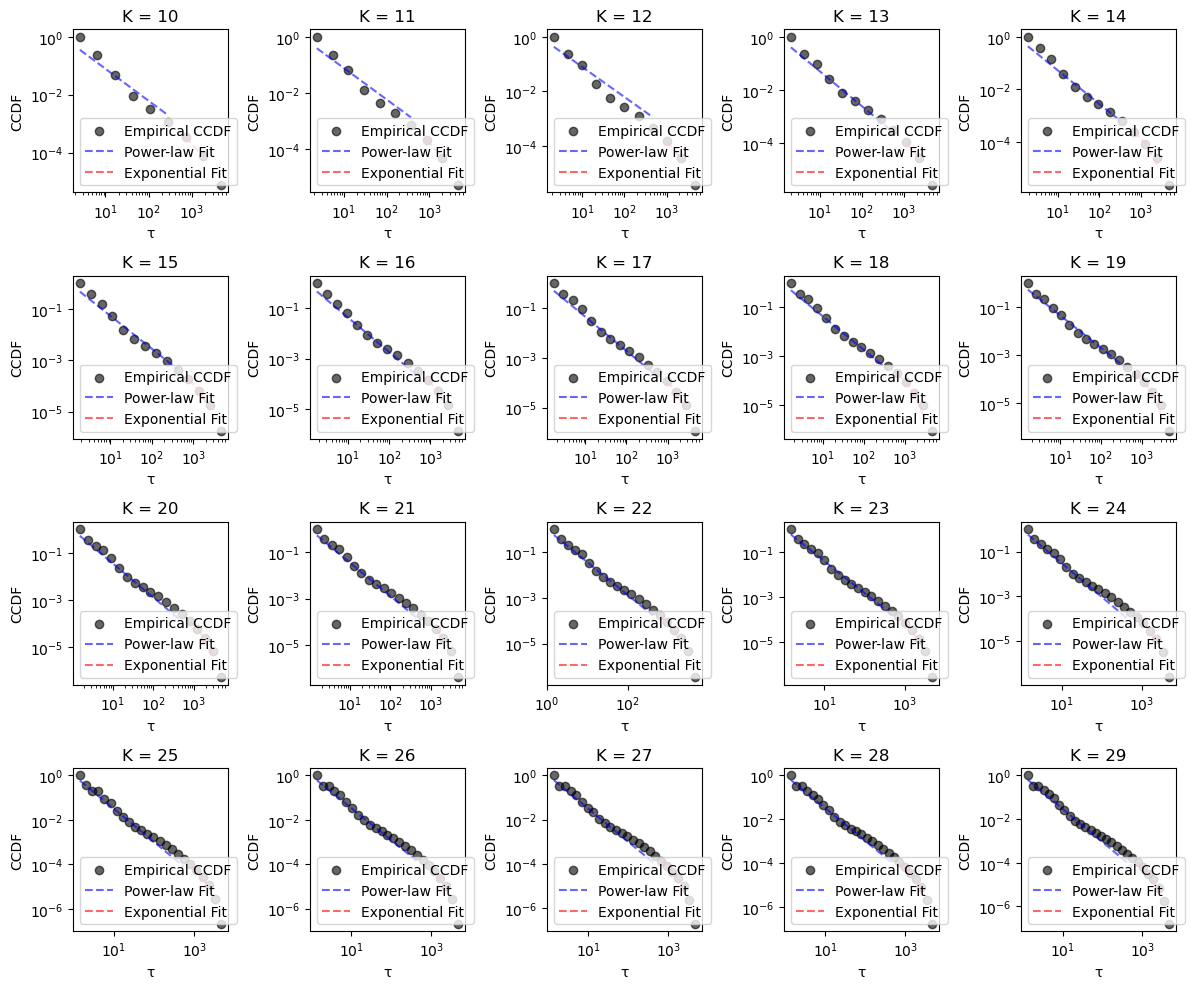

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def empirical_ccdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    cdf = np.cumsum(counts[::-1])[::-1]  # Reverse cumulative sum
    ccdf = cdf / cdf[0]  # Normalize to 1
    return bin_edges[1:], ccdf

def empirical_pdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    pdf = counts / np.sum(counts)  # Normalize to sum to 1
    return bin_edges[1:], pdf

def power_law(x, gamma):
    return x ** -gamma

def exponential(x, A, beta):
    return A * np.exp(-beta * x)


def fit_bimodal(data, tau_0, tau_1, t, K):
    data = np.array(data)  # Ensure data is a NumPy array

    # Compute empirical CCDF
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)), K)
    #print(bins)
    x_vals, ccdf_vals = empirical_ccdf(data, bins)

    # Fit power-law
    pl_x = x_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    pl_y = ccdf_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    popt_pl, _ = curve_fit(lambda x, gamma: power_law(x, gamma), pl_x, pl_y,p0=[1.5])

    # Fit exponential
    exp_x = x_vals[x_vals > tau_0 + t]
    exp_y = ccdf_vals[x_vals > tau_0 + t]
    
    if len(exp_x) > 0 and len(exp_y) > 0:
        popt_exp, _ = curve_fit(lambda x, A, beta: exponential(x, A, beta), exp_x, exp_y,p0=[1, 0.01])
    else:
        print("Warning: No valid exponential data. Adjust τ₀ or t.")
        popt_exp = [np.nan, np.nan]  # Placeholder for failed fit
    
    return x_vals, ccdf_vals, popt_pl[0], popt_exp  # Ensure popt_exp is returned

def plot_ccdf_comparison(data, tau_0, tau_1, t):
    plt.figure(figsize=(12, 10))
    
    for i, K in enumerate(range(10, 30)):
        x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)
        
        # Compute theoretical CCDF
        pl_x = x_vals[x_vals < tau_0 - t]
        exp_x = x_vals[(x_vals > tau_0 + t) & (x_vals < 3000)]
        
        pl_ccdf = power_law(pl_x, gamma)
        exp_ccdf = exponential(exp_x, *popt_exp)
        
        plt.subplot(4,5, i + 1)
        plt.scatter(x_vals, ccdf_vals, label='Empirical CCDF', color='black', alpha=0.6)
        plt.plot(pl_x, pl_ccdf, color='blue',linestyle='dashed', label='Power-law Fit', alpha=0.6)
        plt.plot(exp_x, exp_ccdf, color='red', linestyle='dashed',label='Exponential Fit', alpha=0.6)
        
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('τ')
        plt.ylabel('CCDF')
        plt.title(f'K = {K}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example Usage (Replace with actual data)
tau_1 = 10
t = 20
K = 30
best_tau0 = 600
# best_tau0, _, _ = find_best_tau0(data, tau_1, t, K)
plot_ccdf_comparison(data, best_tau0, tau_1, t)

In [22]:
np.logspace(np.log10(min(data)), np.log10(max(data)), 1)

array([1.])

In [1]:
def compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K):
    # Compute model CCDF
    model_ccdf = np.piecewise(
        x_vals,
        [x_vals < tau_0 - t, x_vals > tau_0 + t],
        [lambda x: power_law(x, gamma), lambda x: exponential(x, *popt_exp)]
    )
    
    # Ensure numerical stability
    ccdf_vals = np.where(ccdf_vals <= 0, 1e-10, ccdf_vals)
    model_ccdf = np.where(model_ccdf <= 0, 1e-10, model_ccdf)
    
    # Select K bins for error calculation

    num,denom=0,0
    # Compute error function based on the given formula
    for k in range(1,K+1):
        indices = np.linspace(0, len(x_vals) - 1, k, dtype=int)
        ccdf_vals_k = ccdf_vals[indices]
        model_ccdf_k = model_ccdf[indices]
   
        num += np.sum(np.abs(np.log(model_ccdf_k) - np.log(ccdf_vals_k)))
        denom += np.sum(np.abs(np.log(model_ccdf_k) + np.log(ccdf_vals_k)))
    
    # Avoid division by zero
    if denom == 0:
        return np.nan  # Assign NaN if denominator is zero
    
    error = 2 * num / denom
    return error

tau0_values = np.linspace(400, 1400, 50)
e_lst = []

for tau_0 in tau0_values:
    x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)

    error = compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K)
    e_lst.append(error)

NameError: name 'np' is not defined

In [94]:
x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)

error = compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, 40)


/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_12974/419414133.py:20: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-beta * x)


Best tau_0: 1114.2857142857142


/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_74085/3240827.py:20: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-beta * x)


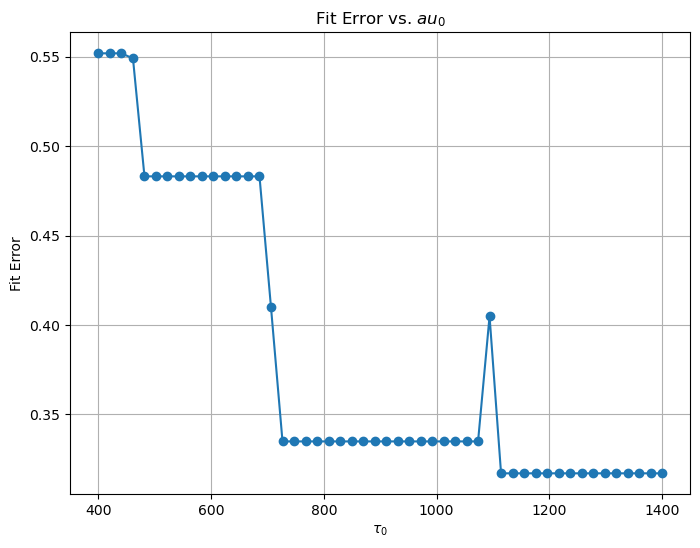

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def empirical_ccdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    cdf = np.cumsum(counts[::-1])[::-1]  # Reverse cumulative sum
    ccdf = cdf / cdf[0]  # Normalize to 1
    return bin_edges[1:], ccdf

def empirical_pdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    pdf = counts / np.sum(counts)  # Normalize to sum to 1
    return bin_edges[1:], pdf

def power_law(x, gamma):
    return x ** -gamma

def exponential(x, A, beta):
    return A * np.exp(-beta * x)

def fit_bimodal(data, tau_0, tau_1, t, K):
    data = np.array(data)  # Ensure data is a NumPy array

    # Compute empirical CCDF
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)), K)
    x_vals, ccdf_vals = empirical_ccdf(data, bins)

    # Fit power-law
    pl_x = x_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    pl_y = ccdf_vals[(x_vals >= tau_1) & (x_vals < tau_0 - t)]
    popt_pl, _ = curve_fit(lambda x, gamma: power_law(x, gamma), pl_x, pl_y, p0=[1.5])

    # Fit exponential
    exp_x = x_vals[x_vals > tau_0 + t]
    exp_y = ccdf_vals[x_vals > tau_0 + t]
    
    if len(exp_x) > 0 and len(exp_y) > 0:
        popt_exp, _ = curve_fit(lambda x, A, beta: exponential(x, A, beta), exp_x, exp_y, p0=[1, 0.01])
    else:
        popt_exp = [np.nan, np.nan]  # Placeholder for failed fit
    
    return x_vals, ccdf_vals, popt_pl[0], popt_exp

def compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K):
    # Compute model CCDF
    model_ccdf = np.piecewise(
        x_vals,
        [x_vals < tau_0 - t, x_vals > tau_0 + t],
        [lambda x: power_law(x, gamma), lambda x: exponential(x, *popt_exp)]
    )
    
    # Ensure numerical stability
    ccdf_vals = np.where(ccdf_vals <= 0, 1e-10, ccdf_vals)
    model_ccdf = np.where(model_ccdf <= 0, 1e-10, model_ccdf)
    
    num, denom = 0, 0
    # Compute error function based on the given formula
    for k in range(1, K + 1):
        indices = np.linspace(0, len(x_vals) - 1, k, dtype=int)
        ccdf_vals_k = ccdf_vals[indices]
        model_ccdf_k = model_ccdf[indices]
   
        num += np.sum(np.abs(np.log(model_ccdf_k) - np.log(ccdf_vals_k)))
        denom += np.sum(np.abs(np.log(model_ccdf_k) + np.log(ccdf_vals_k)))
    
    # Avoid division by zero
    if denom == 0:
        return np.nan  # Assign NaN if denominator is zero
    
    error = 2 * num / denom
    return error

def find_best_tau0(data, tau_1, t, K):
    tau0_values = np.linspace(400, 1400, 50)
    e_lst = []
    
    for tau_0 in tau0_values:
        x_vals, ccdf_vals, gamma, popt_exp = fit_bimodal(data, tau_0, tau_1, t, K)
        error = compute_error(x_vals, ccdf_vals, gamma, popt_exp, tau_0, t, K)
        e_lst.append(error)
    
    best_tau0 = tau0_values[np.nanargmin(e_lst)]  # Find tau_0 with the minimum error
    return best_tau0, tau0_values, e_lst

# Example Usage (Replace with actual data)
tau_1 = 5
t = 10
K = 30

best_tau0, tau0_values, e_lst = find_best_tau0(data, tau_1, t, K)
print(f'Best tau_0: {best_tau0}')

# Plot error vs tau_0
plt.figure(figsize=(8, 6))
plt.plot(tau0_values, e_lst, marker='o', linestyle='-')
plt.xlabel(r'$\tau_0$')
plt.ylabel('Fit Error')
plt.title('Fit Error vs. $\tau_0$')
plt.grid(True)
plt.show()


In [100]:
len(tau0_values)

50

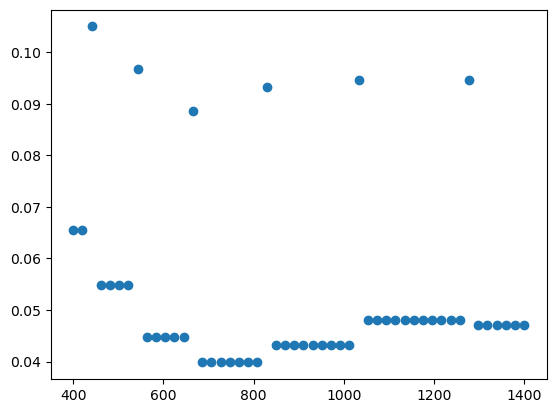

In [101]:
plt.scatter(tau0_values,e_lst)

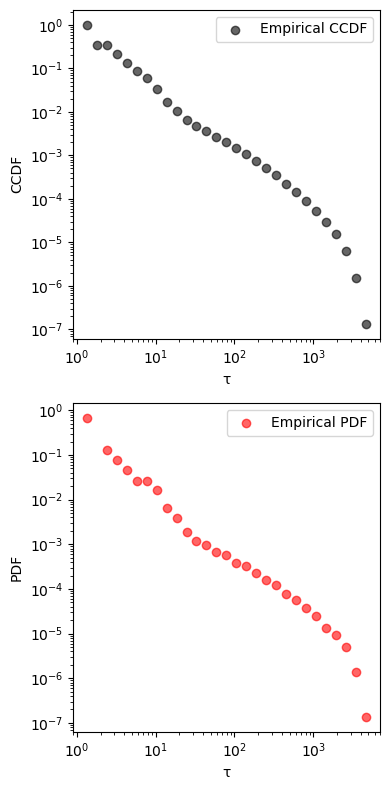

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_ccdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    cdf = np.cumsum(counts[::-1])[::-1]  # Reverse cumulative sum
    ccdf = cdf / cdf[0]  # Normalize to 1
    return bin_edges[1:], ccdf

def empirical_pdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    pdf = counts / np.sum(counts)  # Normalize to sum to 1
    return bin_edges[1:], pdf

def plot_empirical_ccdf_pdf(data, K):
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)), K)
    x_vals_ccdf, ccdf_vals = empirical_ccdf(data, bins)
    x_vals_pdf, pdf_vals = empirical_pdf(data, bins)
    
    plt.figure(figsize=(4,8))
    
    # Plot CCDF
    plt.subplot(2, 1, 1)
    plt.scatter(x_vals_ccdf, ccdf_vals, color='black', alpha=0.6, label='Empirical CCDF')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('τ')
    plt.ylabel('CCDF')
    plt.legend()
    
    # Plot PDF
    plt.subplot(2, 1, 2)
    plt.scatter(x_vals_pdf, pdf_vals, color='red', alpha=0.6, label='Empirical PDF')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('τ')
    plt.ylabel('PDF')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example Usage (Replace with actual data)
K = 30
plot_empirical_ccdf_pdf(data, K)


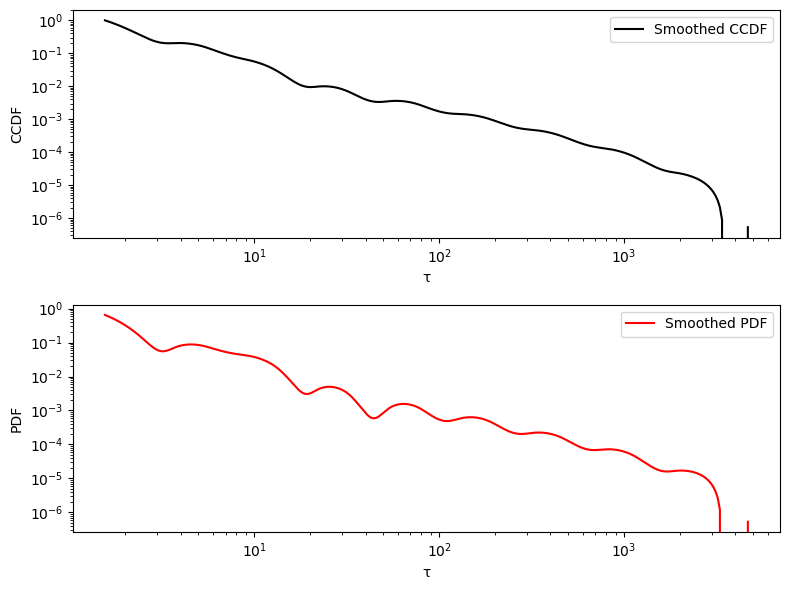

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def empirical_ccdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    cdf = np.cumsum(counts[::-1])[::-1]  # Reverse cumulative sum
    ccdf = cdf / cdf[0]  # Normalize to 1
    return bin_edges[1:], ccdf

def empirical_pdf(data, bins):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    pdf = counts / np.sum(counts)  # Normalize to sum to 1
    return bin_edges[1:], pdf

def smooth_curve(x, y, num_points=300):
    spline = make_interp_spline(x, y, k=3)  # Cubic spline interpolation
    x_smooth = np.logspace(np.log10(min(x)), np.log10(max(x)), num_points)
    y_smooth = spline(x_smooth)
    return x_smooth, y_smooth

def plot_empirical_ccdf_pdf(data, K):
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)), K)
    x_vals_ccdf, ccdf_vals = empirical_ccdf(data, bins)
    x_vals_pdf, pdf_vals = empirical_pdf(data, bins)
    
    x_smooth_ccdf, y_smooth_ccdf = smooth_curve(x_vals_ccdf, ccdf_vals)
    x_smooth_pdf, y_smooth_pdf = smooth_curve(x_vals_pdf, pdf_vals)
    
    plt.figure(figsize=(8,6))
    
    # Plot CCDF
    plt.subplot(2, 1, 1)
    plt.plot(x_smooth_ccdf, y_smooth_ccdf, color='black', label='Smoothed CCDF')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('τ')
    plt.ylabel('CCDF')
    plt.legend()
    
    # Plot PDF
    plt.subplot(2, 1, 2)
    plt.plot(x_smooth_pdf, y_smooth_pdf, color='red', label='Smoothed PDF')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('τ')
    plt.ylabel('PDF')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example Usage (Replace with actual data)
K = 20
plot_empirical_ccdf_pdf(data, K)

In [58]:
filtered_data = [x for x in data if x <= 600]


In [77]:
data = team_t[-1]

In [5]:
def add1(lst):
    return [x + 1 for x in lst]

In [29]:
import powerlaw
data = add1(team_t[-1])  # Your dataset
fit = powerlaw.Fit(data,xmax=100,xmin=1)

alpha = fit.alpha
xmin = fit.xmin
print(f"Power-law exponent: {alpha}, xmin: {xmin}")

Power-law exponent: 1.8329583369187623, xmin: 1.0


In [9]:
print(f"Max value: {max(data)}")

Max value: 4671


In [11]:
print(f"Min value: {min(data)}")

Min value: 1


In [ ]:
data

AttributeError: 'list' object has no attribute 'T'

Calculating best minimal value for power law fit
Optimal xmin: 1.0%
Estimated alpha: 1.4030132261473776
KS statistic: 0.0521645787388364


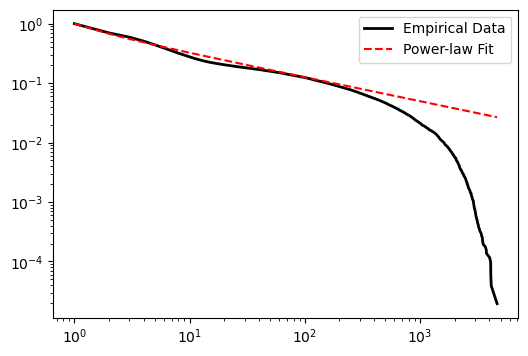

In [30]:
# Fit power-law model
fit = powerlaw.Fit(data, discrete=True)  # Set discrete=False if data is continuous

# Get estimated xmin
xmin = fit.xmin
alpha = fit.alpha
ks = fit.power_law.KS() 

print(f"Optimal xmin: {xmin}")
print(f"Estimated alpha: {alpha}")
print(f"KS statistic: {ks}")

# Plot CCDF with fitted power-law
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
fit.plot_ccdf(label="Empirical Data", color="black", linewidth=2)

fit.power_law.plot_ccdf(ax=ax, linestyle="--", label="Power-law Fit", color="red")
plt.legend()
plt.show()

In [61]:
max(filtered_data)

600

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Power-Law: alpha = 1.593929284734679, xmin = 3.0
Truncated Power-Law: alpha = 1.464405070501318, lambda = 0.0009513472674346289, xmin = 3.0
Log-Normal: mu = -5.946838883355204, sigma = 4.070885077346311, xmin = 3.0
Double Log-Normal: Shape1 = 1.657424877264853, Scale1 = 4.824935261397389
Double Log-Normal: Shape2 = 1.4640182556545178, Scale2 = 17.612377203068228


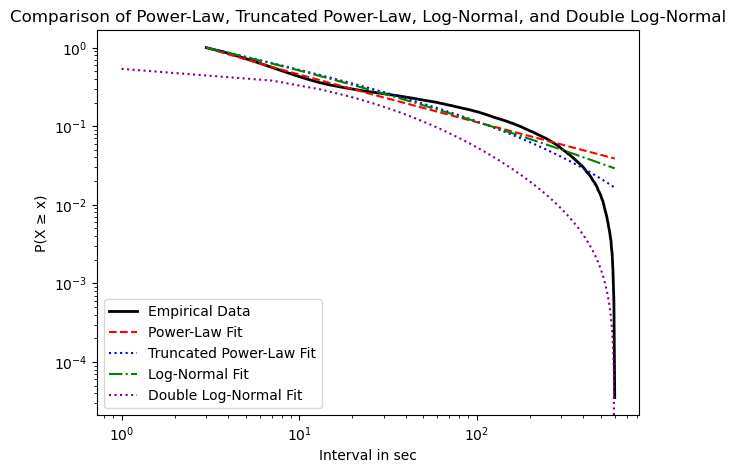

In [62]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Load dataset (replace with actual data)
#data = np.random.zipf(2.5, 1000)  # Example dataset

# Fit models
fit = powerlaw.Fit(filtered_data, discrete=True)
fit_trunc = powerlaw.Fit(filtered_data, discrete=True, distribution="truncated_power_law")
fit_lognormal = powerlaw.Fit(filtered_data, discrete=True, distribution="lognormal")

# Extract parameters
xmin = fit.xmin
alpha = fit.alpha
alpha_trunc = fit_trunc.truncated_power_law.alpha
lambda_trunc = fit_trunc.truncated_power_law.parameter2
mu_lognorm = fit_lognormal.lognormal.mu
sigma_lognorm = fit_lognormal.lognormal.sigma

print(f"Power-Law: alpha = {alpha}, xmin = {xmin}")
print(f"Truncated Power-Law: alpha = {alpha_trunc}, lambda = {lambda_trunc}, xmin = {xmin}")
print(f"Log-Normal: mu = {mu_lognorm}, sigma = {sigma_lognorm}, xmin = {xmin}")

# Fit Double Log-Normal (Manually)
shape1, loc1, scale1 = lognorm.fit(filtered_data, floc=0)  # First log-normal
import numpy as np

# Ensure data is a NumPy array before applying boolean indexing
filtered_data = np.array(filtered_data)

# Select only the upper tail (e.g., above the median)
upper_tail = filtered_data[filtered_data > np.percentile(filtered_data, 50)]

# Ensure upper_tail is not empty before fitting
if len(upper_tail) > 0:
    shape2, loc2, scale2 = lognorm.fit(upper_tail, floc=0)
else:
    print("Error: No data points above the 50th percentile.")
print(f"Double Log-Normal: Shape1 = {shape1}, Scale1 = {scale1}")
print(f"Double Log-Normal: Shape2 = {shape2}, Scale2 = {scale2}")

# Generate Double Log-Normal CCDF
x = np.linspace(min(filtered_data), max(filtered_data), 100)
pdf1 = lognorm.pdf(x, shape1, loc1, scale1)  # First log-normal
pdf2 = lognorm.pdf(x, shape2, loc2, scale2)  # Second log-normal (tail)
ccdf_dln = 1 - np.cumsum(pdf1 + pdf2) / np.sum(pdf1 + pdf2)

# Plot CCDF with all fitted models
fig, ax = plt.subplots(figsize=(7, 5))

# Plot Empirical Data
fit.plot_ccdf(ax=ax, color="black", linewidth=2, label="Empirical Data")

# Plot Power-Law Fit
fit.power_law.plot_ccdf(ax=ax, linestyle="--", color="red", label="Power-Law Fit")

# Plot Truncated Power-Law Fit
fit_trunc.truncated_power_law.plot_ccdf(ax=ax, linestyle=":", color="blue", label="Truncated Power-Law Fit")

# Plot Log-Normal Fit
fit_lognormal.lognormal.plot_ccdf(ax=ax, linestyle="dashdot", color="green", label="Log-Normal Fit")

# Plot Double Log-Normal Fit (Manually Computed)
ax.plot(x, ccdf_dln, linestyle="dotted", color="purple", label="Double Log-Normal Fit")

# Labels & Legend
plt.xlabel("Interval in sec")
plt.ylabel("P(X ≥ x)")
plt.legend()
plt.title("Comparison of Power-Law, Truncated Power-Law, Log-Normal, and Double Log-Normal")

plt.show()



Double Pareto Log-Normal Approximation: mu = 1.7881609629953996, sigma = 1.9429463579842328


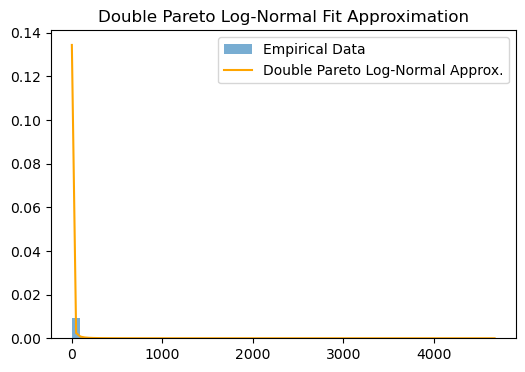

In [38]:
from scipy.stats import lognorm

# Fit Log-Normal First
shape, loc, scale = lognorm.fit(data, floc=0)  # Fit log-normal

# Approximate DPLN by modifying log-normal parameters
mu_dpln = np.log(scale)  # Mean in log-space
sigma_dpln = shape       # Standard deviation in log-space

print(f"Double Pareto Log-Normal Approximation: mu = {mu_dpln}, sigma = {sigma_dpln}")

# Generate DPLN PDF
x = np.linspace(min(data), max(data), 100)
pdf_dpln = lognorm.pdf(x, sigma_dpln, loc=0, scale=np.exp(mu_dpln))

# Plot
plt.figure(figsize=(6,4))
plt.hist(data, bins=50, density=True, alpha=0.6, label="Empirical Data")
plt.plot(x, pdf_dpln, color="orange", label="Double Pareto Log-Normal Approx.")
plt.legend()
plt.title("Double Pareto Log-Normal Fit Approximation")
plt.show()



In [32]:
R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')

print(f"Log-likelihood Ratio (Power-Law vs Lognormal): {R_ln}, p-value: {p_ln}")
print(f"Log-likelihood Ratio (Power-Law vs Exponential): {R_exp}, p-value: {p_exp}")

Log-likelihood Ratio (Power-Law vs Lognormal): -785.5140579823076, p-value: 1.3126119578741283e-290
Log-likelihood Ratio (Power-Law vs Exponential): 88998.47436696573, p-value: 0.0


In [42]:
with open('/Users/rivers/Desktop/your_file.txt', 'w') as f:
    for line in data:
        f.write(f"{line}\n")

/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_20161/263536755.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  params_tln, _ = curve_fit(truncated_lognormal_ccdf, x_vals, ccdf_empirical, p0=[shape_ln, scale_ln, truncation_guess])


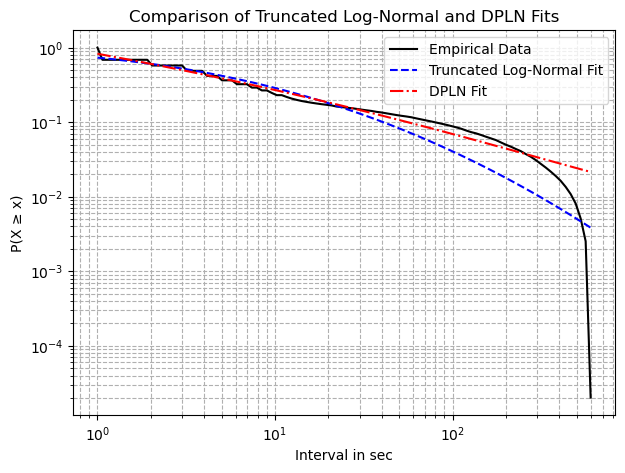

('Truncated Log-Normal Fit: shape=1.945, scale=3.368, truncation=-122265.806',
 'DPLN Fit: shape_ln=3.809, scale_ln=2.989, alpha=0.274, beta=-0.000')

In [63]:
from scipy.optimize import curve_fit
empirical_data = filtered_data

# Fit distributions
fit_powerlaw = powerlaw.Fit(empirical_data, xmin=1, discrete=False)
fit_truncated_pl = powerlaw.Fit(empirical_data, xmin=1, discrete=False, distribution="truncated_power_law")

# Fit Log-Normal
shape_ln, loc_ln, scale_ln = lognorm.fit(empirical_data, floc=0)

# Fit Weibull (Stretched Exponential)

# Fit Pareto (Power-Law) as an alternative check

# Generate CCDF values
x_vals = np.logspace(np.log10(min(empirical_data)), np.log10(max(empirical_data)), 100)
ccdf_empirical = np.array([np.sum(empirical_data >= x) / len(empirical_data) for x in x_vals])
ccdf_ln = 1 - lognorm.cdf(x_vals, s=shape_ln, scale=scale_ln)


# Define a truncated log-normal CCDF function
def truncated_lognormal_ccdf(x, shape, scale, trunc):
    """CCDF for a truncated log-normal distribution."""
    return 1 - (lognorm.cdf(x, s=shape, scale=scale) - lognorm.cdf(trunc, s=shape, scale=scale))

# Initial guess for truncation threshold
truncation_guess = np.max(filtered_data) * 0.9  

# Fit truncated log-normal model
x_vals = np.logspace(np.log10(min(filtered_data)), np.log10(max(filtered_data)), 100)
ccdf_empirical = np.array([np.sum(filtered_data >= x) / len(filtered_data) for x in x_vals])

params_tln, _ = curve_fit(truncated_lognormal_ccdf, x_vals, ccdf_empirical, p0=[shape_ln, scale_ln, truncation_guess])
shape_tln, scale_tln, trunc_tln = params_tln

# Define a double Pareto log-normal (DPLN) CCDF function (simplified)
def dpln_ccdf(x, shape_ln, scale_ln, alpha, beta):
    """Approximate CCDF for a Double Pareto Log-Normal distribution."""
    return (1 - lognorm.cdf(x, s=shape_ln, scale=scale_ln)) * ((x / scale_ln) ** -alpha) * np.exp(-beta * (x - scale_ln))

# Fit the DPLN model
params_dpln, _ = curve_fit(dpln_ccdf, x_vals, ccdf_empirical, p0=[shape_ln, scale_ln, 1.5, 0.01])
shape_dpln, scale_dpln, alpha_dpln, beta_dpln = params_dpln

# Generate CCDFs for the models
ccdf_tln = truncated_lognormal_ccdf(x_vals, shape_tln, scale_tln, trunc_tln)
ccdf_dpln = dpln_ccdf(x_vals, shape_dpln, scale_dpln, alpha_dpln, beta_dpln)

# Plot comparison
plt.figure(figsize=(7, 5))
plt.loglog(x_vals, ccdf_empirical, 'k-', label='Empirical Data')
plt.loglog(x_vals, ccdf_tln, 'b--', label='Truncated Log-Normal Fit')
plt.loglog(x_vals, ccdf_dpln, 'r-.', label='DPLN Fit')

plt.xlabel("Interval in sec")
plt.ylabel("P(X ≥ x)")
plt.title("Comparison of Truncated Log-Normal and DPLN Fits")
plt.legend()
plt.grid(True, which="both", linestyle="--")

# Show plot
plt.show()

# Print fitted parameters
tln_params = f"Truncated Log-Normal Fit: shape={shape_tln:.3f}, scale={scale_tln:.3f}, truncation={trunc_tln:.3f}"
dpln_params = f"DPLN Fit: shape_ln={shape_dpln:.3f}, scale_ln={scale_dpln:.3f}, alpha={alpha_dpln:.3f}, beta={beta_dpln:.3f}"
(tln_params, dpln_params)


In [47]:
# Refit models with better constraints

# Define a constrained truncated log-normal CCDF function
def constrained_truncated_lognormal_ccdf(x, shape, scale, trunc):
    """CCDF for a truncated log-normal distribution with manual truncation."""
    trunc = max(trunc, np.percentile(empirical_data, 99))  # Set a reasonable truncation limit
    return 1 - (lognorm.cdf(x, s=shape, scale=scale) - lognorm.cdf(trunc, s=shape, scale=scale))

# Define a constrained DPLN CCDF function with positive beta
def constrained_dpln_ccdf(x, shape_ln, scale_ln, alpha, beta):
    """CCDF for a Double Pareto Log-Normal distribution with bounded parameters."""
    alpha = max(alpha, 0.1)  # Ensure alpha is positive
    beta = max(beta, 0.01)  # Ensure beta is positive (prevents invalid decay behavior)
    return (1 - lognorm.cdf(x, s=shape_ln, scale=scale_ln)) * ((x / scale_ln) ** -alpha) * np.exp(-beta * (x - scale_ln))

# Fit constrained truncated log-normal model with manually set truncation
manual_truncation = np.percentile(data, 99.5)  # Manually choosing a more reasonable truncation point
params_tln_manual, _ = curve_fit(
    constrained_truncated_lognormal_ccdf, x_vals, ccdf_empirical,
    p0=[shape_ln, scale_ln, manual_truncation]
)
shape_tln_m, scale_tln_m, trunc_tln_m = params_tln_manual

# Fit constrained DPLN model forcing positive beta
params_dpln_constrained, _ = curve_fit(
    constrained_dpln_ccdf, x_vals, ccdf_empirical, p0=[shape_ln, scale_ln, 1.5, 0.1]
)
shape_dpln_c, scale_dpln_c, alpha_dpln_c, beta_dpln_c = params_dpln_constrained

# Generate CCDFs for improved models
ccdf_tln_manual = constrained_truncated_lognormal_ccdf(x_vals, shape_tln_m, scale_tln_m, trunc_tln_m)
ccdf_dpln_constrained = constrained_dpln_ccdf(x_vals, shape_dpln_c, scale_dpln_c, alpha_dpln_c, beta_dpln_c)

# Plot comparison of refined models
plt.figure(figsize=(7, 5))
plt.loglog(x_vals, ccdf_empirical, 'k-', label='Empirical Data')
plt.loglog(x_vals, ccdf_tln_manual, 'b--', label='Manual Truncated Log-Normal Fit')
plt.loglog(x_vals, ccdf_dpln_constrained, 'r-.', label='Constrained DPLN Fit')

plt.xlabel("Interval in sec")
plt.ylabel("P(X ≥ x)")
plt.title("Improved Comparison of Truncated Log-Normal and DPLN Fits")
plt.legend()
plt.grid(True, which="both", linestyle="--")

# Show plot
plt.show()

# Print refined fitted parameters
tln_manual_params = f"Manual Truncated Log-Normal Fit: shape={shape_tln_m:.3f}, scale={scale_tln_m:.3f}, truncation={trunc_tln_m:.3f}"
dpln_constrained_params = f"Constrained DPLN Fit: shape_ln={shape_dpln_c:.3f}, scale_ln={scale_dpln_c:.3f}, alpha={alpha_dpln_c:.3f}, beta={beta_dpln_c:.3f}"
(tln_manual_params, dpln_constrained_params)



NameError: name 'x_vals' is not defined

In [1]:
def calculate_differences(int_list):
    # Ensure the list has at least 2 elements
    if len(int_list) < 2:
        raise ValueError("The list must contain at least 2 elements.")

    # Calculate the differences between consecutive elements
    differences = [int_list[i+1] - int_list[i] for i in range(len(int_list) - 1)]
    
    return differences

In [2]:
interval_sample = []
count = 0
for obj in objs:
    time = []
    if len(obj['chat']) > 1:
        for chat in obj['chat']:
            time.append(chat['time'])
        diff = calculate_differences(time)
    interval_sample += diff

NameError: name 'objs' is not defined

In [4]:
winning_sample = []
losing_sample = []
radiant = [0,1,2,3,4]
dire = [5,6,7,8,9]
count = 0

winning_L = []
losing_L = []



for obj in objs:
    winning_team_t = []
    losing_team_t = []
    wining_diff = []
    losing_diff = []
    w, l = True, True
    if len(obj['chat']) > 1:
        
        for chat in obj['chat']:
            if 'slot' in list(chat.keys()):
                if (chat['slot'] in radiant and obj['radiant_win']==True) or (chat['slot'] in dire and obj['radiant_win']==False):
                    winning_team_t.append(chat['time'])
                    # print('here')
                    if w == False:
                        winning_L.append(len(str(chat['key'])))
                    w = False
                else:
                    losing_team_t.append(chat['time'])
                    if l == False:
                        losing_L.append(len(str(chat['key'])))
                    l = False
                if len(winning_team_t)>1:
                    wining_diff = calculate_differences(winning_team_t)
                if len(losing_team_t)>1:
                    losing_diff = calculate_differences(losing_team_t)
            count+=1
    winning_sample += wining_diff
    losing_sample += losing_diff

### Original Power Law Distribution

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns



def remove_0(my_list):
    smallest = min(my_list)

    # Remove all occurrences of the smallest value
    filtered_list = [x for x in my_list if x != smallest]
    return filtered_list


def plot_ccdf(mode): # captain, allpick, allrandom, rank
    palette = sns.color_palette("Set1")
    with open('%s_matches_2000.json'%(mode), 'r') as file:
        objs = json.load(file, object_hook=decimal_decoder)
    # interval_sample = []
    # for obj in objs:
    #     time = []
    #     if len(obj['chat']) > 1:
    #         for chat in obj['chat']:
    #             time.append(chat['time'])
    #             print(chat['time'])
    #         diff = calculate_differences(time)
    #     print(time)
    #     interval_sample += diff

    winning_sample = []
    losing_sample = []
    radiant = [0,1,2,3,4]
    dire = [5,6,7,8,9]
    count = 0

    winning_L = []
    losing_L = []



    for obj in objs:
        winning_team_t = []
        losing_team_t = []
        wining_diff = []
        losing_diff = []
        w, l = True, True
        if len(obj['chat']) > 1:
            
            for chat in obj['chat']:
                if 'slot' in list(chat.keys()):
                    if (chat['slot'] in radiant and obj['radiant_win']==True) or (chat['slot'] in dire and obj['radiant_win']==False):
                        winning_team_t.append(chat['time'])
                        # print('here')
                        if w == False:
                            winning_L.append(len(str(chat['key'])))
                        w = False
                    else:
                        losing_team_t.append(chat['time'])
                        if l == False:
                            losing_L.append(len(str(chat['key'])))
                        l = False
                    if len(winning_team_t)>1:
                        wining_diff = calculate_differences(winning_team_t)
                    if len(losing_team_t)>1:
                        losing_diff = calculate_differences(losing_team_t)
                count+=1
        winning_sample += wining_diff
        losing_sample += losing_diff

    
    winning_sample=[x + 1 for x in winning_sample]
    losing_sample=[x + 1 for x in losing_sample]

    # winning_sample = remove_0(winning_sample)
    # losing_sample = remove_0(losing_sample)

    ccdf1 = []
    x1 = []
    ccdf2 = []
    x2 = []


    
    sort_sample1 = sorted(winning_sample)
    counter1 = Counter(sort_sample1)
    l1 = len(winning_sample)
    sum1 = 0

    sort_sample2 = sorted(losing_sample)
    counter2 = Counter(sort_sample2)
    l2 = len(losing_sample)
    sum2 = 0

    for key in counter1.keys():
        ccdf1.append(1-(sum1/l1))
        sum1 += counter1[key]
        x1.append(key)

    for key in counter2.keys():
        ccdf2.append(1-(sum2/l2))
        sum2 += counter2[key]
        x2.append(key)
    
    plt.figure(figsize=(10, 7))

    plt.plot(x1, ccdf1,label='Won',color=palette[0])
    plt.plot(x2, ccdf2,label='Lost',color=palette[1])

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('Interval in sec', fontsize=18)
    plt.ylabel('CCDF', fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(fontsize=14)
    plt.title('%s mode'%(mode), fontsize=20)

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.savefig('%s_corrected_ccdf.pdf'%(mode))
    # plt.show()

    wining_dist = Counter(winning_sample)
    losing_dist = Counter(losing_sample)

    x1=[]
    y1=[]
    for i in sorted(wining_dist): 
        x1.append(i)
        y1.append(wining_dist[i]/len(winning_sample))
    x2=[]
    y2=[]
    for i in sorted(losing_dist):
        x2.append(i)
        y2.append(losing_dist[i]/len(losing_sample))


    plt.figure(figsize=(10,7))
    

    plt.plot(x1,y1,label='Won',color=palette[0])
    plt.plot(x2,y2,label='Lost',color=palette[1])
    plt.xlabel('Interval in sec', fontsize=17)
    plt.ylabel('$P$', fontsize=17)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(['winning','losing'])
    plt.yscale('log')
    plt.xscale('log')
    plt.title('%s Mode Matches' %(mode), fontsize=19)

    # all_pick={'x1':x1,'y1':y1,'x2':x2,'y2':y2}
    plt.savefig('%s_corrected_pdf.pdf'%(mode))
    plt.show()

    return winning_sample, losing_sample

Calculating best minimal value for power law fit
Power-Law Fit: alpha = 1.5939764612718248, xmin = 3.0
Exponential Fit: lambda = 0.0007803347872937748


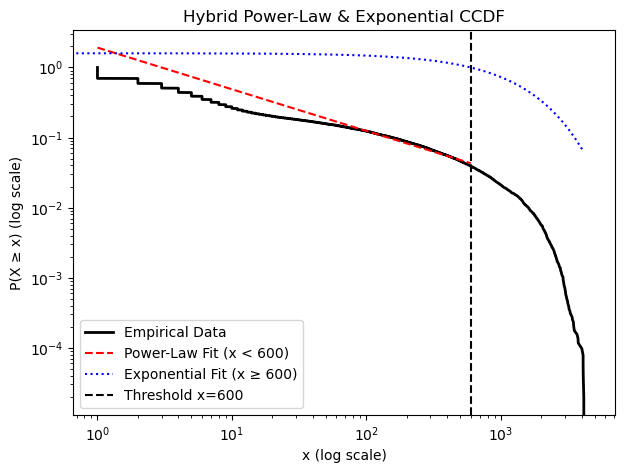

In [ ]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
from scipy.stats import expon

# Load dataset (replace with actual data)
data = np.array(data)  # Ensure NumPy array

# Define the threshold (x = 600)
threshold = 600

# Split the data
data_powerlaw = data[data < threshold]  # Fit Power-Law for x < 600
data_exponential = data[data >= threshold]  # Fit Exponential for x ≥ 600

# Fit Power-Law for x < 600
fit_powerlaw = powerlaw.Fit(data_powerlaw, discrete=True)
alpha = fit_powerlaw.alpha
xmin = fit_powerlaw.xmin

# Fit Exponential for x ≥ 600
lambda_exp = 1 / np.mean(data_exponential)  # Exponential rate (1 / mean)

print(f"Power-Law Fit: alpha = {alpha}, xmin = {xmin}")
print(f"Exponential Fit: lambda = {lambda_exp}")

# Generate CCDF for Empirical Data
sorted_data = np.sort(data)
ccdf_empirical = 1 - np.arange(1, len(data) + 1) / len(data)

# Generate CCDF for Power-Law Fit (x < 600)
x_powerlaw = np.sort(data_powerlaw)
ccdf_powerlaw = (x_powerlaw / xmin) ** (-alpha + 1)  # CCDF formula for Power-Law

# Generate CCDF for Exponential Fit (x ≥ 600)
x_exponential = np.sort(data_exponential)
ccdf_exponential = np.exp(-lambda_exp * (x_exponential - threshold))  # CCDF for Exponential

# Plot CCDF for Empirical Data
plt.figure(figsize=(7,5))
plt.loglog(sorted_data, ccdf_empirical, color="black", linewidth=2, label="Empirical Data")

# Plot Power-Law Fit (x < 600)
plt.loglog(x_powerlaw, ccdf_powerlaw, linestyle="--", color="red", label="Power-Law Fit (x < 600)")

# Plot Exponential Fit (x ≥ 600)
plt.loglog(x_exponential, ccdf_exponential, linestyle=":", color="blue", label="Exponential Fit (x ≥ 600)")

# Labels & Legend
plt.axvline(x=threshold, color="black", linestyle="--", label="Threshold x=600")
plt.xlabel("x (log scale)")
plt.ylabel("P(X ≥ x) (log scale)")
plt.legend()
plt.title("Hybrid Power-Law & Exponential CCDF")

plt.show()

/var/folders/yp/pth812t15q77nnhw33ng68qw0000gn/T/ipykernel_20161/747682378.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_threshold = int(x_threshold)  # Convert to integer


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Optimal x_threshold found: 350
Calculating best minimal value for power law fit
Power-Law Fit: alpha = 1.649936784381492, xmin = 3.0
Exponential Fit (MLE): lambda = 0.0010122114769208997


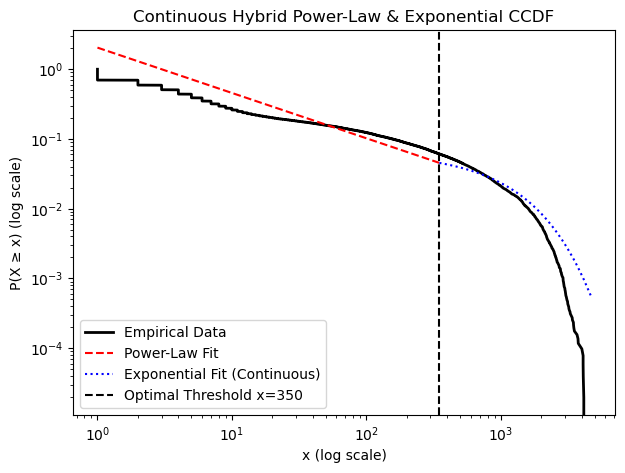

In [99]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import expon

# Load dataset (replace with actual data)
# data = np.random.zipf(2.5, 1000)  # Example dataset
data = np.array(data)  # Ensure NumPy array

# 🔹 **Step 1: Define Log-Likelihood Function to Optimize x_threshold**
def log_likelihood(x_threshold, data):
    """Compute the negative log-likelihood for Power-Law and Exponential mixture."""
    x_threshold = int(x_threshold)  # Convert to integer
    data_powerlaw = data[data < x_threshold]
    data_exponential = data[data >= x_threshold]

    if len(data_powerlaw) < 10 or len(data_exponential) < 10:
        return np.inf  # Avoid underfitting with too few points

    # 🔹 **Fit Power-Law for x < x_threshold**
    fit_powerlaw = powerlaw.Fit(data_powerlaw, discrete=True)
    alpha = fit_powerlaw.alpha
    xmin = fit_powerlaw.xmin

    # 🔹 **Fit Exponential for x ≥ x_threshold using MLE**
    lambda_exp = 1 / np.mean(data_exponential)

    # 🔹 **Compute Log-Likelihood**
    ll_powerlaw = np.sum(np.log((data_powerlaw / xmin) ** (-alpha)))
    ll_exponential = np.sum(np.log(lambda_exp * np.exp(-lambda_exp * (data_exponential - x_threshold))))
    
    return - (ll_powerlaw + ll_exponential)  # Negative log-likelihood for minimization

# 🔹 **Step 2: Optimize x_threshold**
result = minimize(lambda x: log_likelihood(x, data), x0=[350], bounds=[(min(data), max(data))])
optimal_threshold = int(result.x[0])

print(f"Optimal x_threshold found: {optimal_threshold}")

# 🔹 **Step 3: Fit Power-Law & Exponential Using Optimized x_threshold**
data_powerlaw = data[data < optimal_threshold]
data_exponential = data[data >= optimal_threshold]

fit_powerlaw = powerlaw.Fit(data_powerlaw, discrete=True)
alpha = fit_powerlaw.alpha
xmin = fit_powerlaw.xmin

lambda_exp = 1 / np.mean(data_exponential)

print(f"Power-Law Fit: alpha = {alpha}, xmin = {xmin}")
print(f"Exponential Fit (MLE): lambda = {lambda_exp}")

# 🔹 **Step 4: Compute CCDFs and Ensure Continuity**
sorted_data = np.sort(data)
ccdf_empirical = 1 - np.arange(1, len(data) + 1) / len(data)

x_powerlaw = np.sort(data_powerlaw)
ccdf_powerlaw = (x_powerlaw / xmin) ** (-alpha + 1)  # Power-Law CCDF

x_exponential = np.sort(data_exponential)
ccdf_exponential_raw = np.exp(-lambda_exp * (x_exponential - optimal_threshold))  # Raw Exponential CCDF

# 🔹 **Step 5: Scale the Exponential CCDF to Match the Power-Law CCDF at x_threshold**
powerlaw_threshold_ccdf = (optimal_threshold / xmin) ** (-alpha + 1)  # Power-Law CCDF at threshold
ccdf_exponential = powerlaw_threshold_ccdf * ccdf_exponential_raw  # Scale to ensure continuity

# 🔹 **Step 6: Plot CCDFs**
plt.figure(figsize=(7,5))
plt.loglog(sorted_data, ccdf_empirical, color="black", linewidth=2, label="Empirical Data")

# Plot Power-Law Fit
plt.loglog(x_powerlaw, ccdf_powerlaw, linestyle="--", color="red", label="Power-Law Fit")

# Plot Exponential Fit (Continuous)
plt.loglog(x_exponential, ccdf_exponential, linestyle=":", color="blue", label="Exponential Fit (Continuous)")

# Labels & Legend
plt.axvline(x=optimal_threshold, color="black", linestyle="--", label=f"Optimal Threshold x={optimal_threshold}")
plt.xlabel("x (log scale)")
plt.ylabel("P(X ≥ x) (log scale)")
plt.legend()
plt.title("Continuous Hybrid Power-Law & Exponential CCDF")

plt.show()




In [84]:
min(data)

0

In [146]:
import powerlaw

fit = powerlaw.Fit(w)


Calculating best minimal value for power law fit


In [147]:
R, p_value = fit.distribution_compare('power_law', 'lognormal')


In [213]:
p_value

2.5719657950114317e-19

In [239]:
print(f"Alpha (scaling parameter): {fit.power_law.alpha}")
print(f"Xmin (cutoff for power-law fit): {fit.power_law.xmin}")

# Test the goodness-of-fit
R, p_value = fit.distribution_compare('power_law', 'lognormal')

# Display results
if p_value > 0.05:
    print(f"Data plausibly fits a power-law distribution (p = {p_value:.4f}).")
else:
    print(f"Data does not follow a power-law distribution (p = {p_value:.4f}).")

Alpha (scaling parameter): 1.333067800649904
Xmin (cutoff for power-law fit): 1.0
Data does not follow a power-law distribution (p = 0.0000).


In [240]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

loc_exp, scale_exp = stats.expon.fit(w)
lambda_exp = 1 / scale_exp
print(f"Exponential Fit: lambda = {1/scale_exp:.4f}")

# 2. Fit Weibull Stretch Distribution
shape_w, loc_w, scale_w = stats.weibull_min.fit(w)
print(f"Weibull Fit: shape (k) = {shape_w:.4f}, scale = {scale_w:.4f}")

# 3. Fit Cut-Off Power-Law Distribution
fit = powerlaw.Fit(w, xmin=min(w), distribution='truncated_power_law')
alpha_cutoff = fit.truncated_power_law.alpha
lambda_cutoff = fit.truncated_power_law.parameter1
print(f"Cut-off Power-Law Fit: alpha = {alpha_cutoff:.4f}, lambda = {lambda_cutoff:.4f}")


ks_exp, p_exp = stats.kstest(w, 'expon', args=(loc_exp, scale_exp))
ks_weibull, p_weibull = stats.kstest(w, 'weibull_min', args=(shape_w, loc_w, scale_w))

print(f"Exponential KS: statistic = {ks_exp:.4f}, p-value = {p_exp:.4f}")
print(f"Weibull KS: statistic = {ks_weibull:.4f}, p-value = {p_weibull:.4f}")

Exponential Fit: lambda = 0.0083
Weibull Fit: shape (k) = 0.3312, scale = 172.7268
Cut-off Power-Law Fit: alpha = 1.2101, lambda = 1.2101
Exponential KS: statistic = 0.4982, p-value = 0.0000
Weibull KS: statistic = 0.2620, p-value = 0.0000


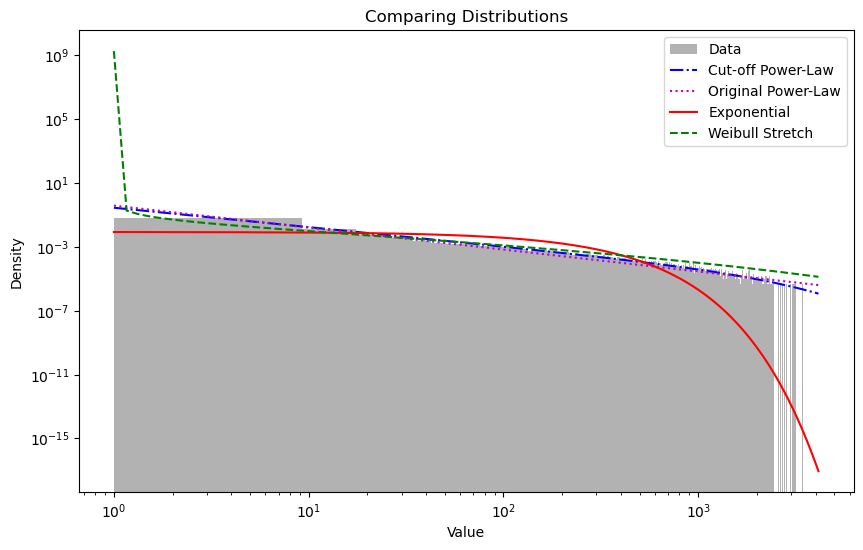

In [241]:
# Generate x values within the range of the data
x = np.linspace(min(w), max(w), len(w))  # Match length of `data`

# Generate PDFs for each distribution
pdf_cutoff = fit.truncated_power_law.pdf(x)
pdf_powerlaw = fit.power_law.pdf(x)  # Original power-law
pdf_exp = stats.expon.pdf(x, loc_exp, scale_exp)
pdf_weibull = stats.weibull_min.pdf(x, shape_w, loc_w, scale_w)

# Plot the distributions and histogram
plt.figure(figsize=(10, 6))

# Histogram of data
plt.hist(w, bins=500, density=True, alpha=0.6, label='Data', color='gray')

# Fit lines
plt.plot(x[:len(pdf_cutoff)], pdf_cutoff, 'b-.', label='Cut-off Power-Law')
plt.plot(x[:len(pdf_powerlaw)], pdf_powerlaw, 'm:', label='Original Power-Law')
plt.plot(x, pdf_exp, 'r-', label='Exponential')
plt.plot(x, pdf_weibull, 'g--', label='Weibull Stretch')

# Log scales
plt.xscale('log')
plt.yscale('log')

# Labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Comparing Distributions')
plt.show()

In [242]:
fit = powerlaw.Fit(w, xmin=min(w), distribution='truncated_power_law')

# Compare truncated power-law with exponential
R_exp, p_exp = fit.distribution_compare('truncated_power_law', 'exponential')

# Compare truncated power-law with Weibull Stretch (stretched exponential)
R_weibull, p_weibull = fit.distribution_compare('truncated_power_law', 'stretched_exponential')

# Results
print(f"Truncated vs Exponential: R = {R_exp:.4f}, p-value = {p_exp:.4f}")
print(f"Truncated vs Weibull Stretch: R = {R_weibull:.4f}, p-value = {p_weibull:.4f}")

Truncated vs Exponential: R = 31028.3883, p-value = 0.0000
Truncated vs Weibull Stretch: R = 495.1186, p-value = 0.0000


In [243]:
import powerlaw
import numpy as np

# Example dataset (replace with your data)

# Fit data to the distributions
fit = powerlaw.Fit(w, xmin=min(w))  # Automatically fits pure power-law and alternatives

# Compare pure power-law with other models
R_powerlaw_cutoff, p_powerlaw_cutoff = fit.distribution_compare('power_law', 'truncated_power_law')
R_powerlaw_exp, p_powerlaw_exp = fit.distribution_compare('power_law', 'exponential')
R_powerlaw_weibull, p_powerlaw_weibull = fit.distribution_compare('power_law', 'stretched_exponential')

# Compare truncated power-law with other models
R_cutoff_exp, p_cutoff_exp = fit.distribution_compare('truncated_power_law', 'exponential')
R_cutoff_weibull, p_cutoff_weibull = fit.distribution_compare('truncated_power_law', 'stretched_exponential')

# Results
print("Comparison Results:")
print(f"Power-law vs Cut-off Power-law: R = {R_powerlaw_cutoff:.4f}, p-value = {p_powerlaw_cutoff:.4f}")
print(f"Power-law vs Exponential: R = {R_powerlaw_exp:.4f}, p-value = {p_powerlaw_exp:.4f}")
print(f"Power-law vs Weibull Stretch: R = {R_powerlaw_weibull:.4f}, p-value = {p_powerlaw_weibull:.4f}")
print(f"Cut-off Power-law vs Exponential: R = {R_cutoff_exp:.4f}, p-value = {p_cutoff_exp:.4f}")
print(f"Cut-off Power-law vs Weibull Stretch: R = {R_cutoff_weibull:.4f}, p-value = {p_cutoff_weibull:.4f}")

Assuming nested distributions


Comparison Results:
Power-law vs Cut-off Power-law: R = -1827.1065, p-value = 0.0000
Power-law vs Exponential: R = 29201.2818, p-value = 0.0000
Power-law vs Weibull Stretch: R = -1331.9879, p-value = 0.0000
Cut-off Power-law vs Exponential: R = 31028.3883, p-value = 0.0000
Cut-off Power-law vs Weibull Stretch: R = 495.1186, p-value = 0.0000


In [244]:
# Fit data to the distributions
fit = powerlaw.Fit(l, xmin=min(l))  # Automatically fits pure power-law and alternatives

# Compare pure power-law with other models
R_powerlaw_cutoff, p_powerlaw_cutoff = fit.distribution_compare('power_law', 'truncated_power_law')
R_powerlaw_exp, p_powerlaw_exp = fit.distribution_compare('power_law', 'exponential')
R_powerlaw_weibull, p_powerlaw_weibull = fit.distribution_compare('power_law', 'stretched_exponential')

# Compare truncated power-law with other models
R_cutoff_exp, p_cutoff_exp = fit.distribution_compare('truncated_power_law', 'exponential')
R_cutoff_weibull, p_cutoff_weibull = fit.distribution_compare('truncated_power_law', 'stretched_exponential')

# Results
print("Comparison Results:")
print(f"Power-law vs Cut-off Power-law: R = {R_powerlaw_cutoff:.4f}, p-value = {p_powerlaw_cutoff:.4f}")
print(f"Power-law vs Exponential: R = {R_powerlaw_exp:.4f}, p-value = {p_powerlaw_exp:.4f}")
print(f"Power-law vs Weibull Stretch: R = {R_powerlaw_weibull:.4f}, p-value = {p_powerlaw_weibull:.4f}")
print(f"Cut-off Power-law vs Exponential: R = {R_cutoff_exp:.4f}, p-value = {p_cutoff_exp:.4f}")
print(f"Cut-off Power-law vs Weibull Stretch: R = {R_cutoff_weibull:.4f}, p-value = {p_cutoff_weibull:.4f}")

Assuming nested distributions


Comparison Results:
Power-law vs Cut-off Power-law: R = -2111.1796, p-value = 0.0000
Power-law vs Exponential: R = 21703.9631, p-value = 0.0000
Power-law vs Weibull Stretch: R = -1726.4611, p-value = 0.0000
Cut-off Power-law vs Exponential: R = 23815.1427, p-value = 0.0000
Cut-off Power-law vs Weibull Stretch: R = 384.7185, p-value = 0.0000


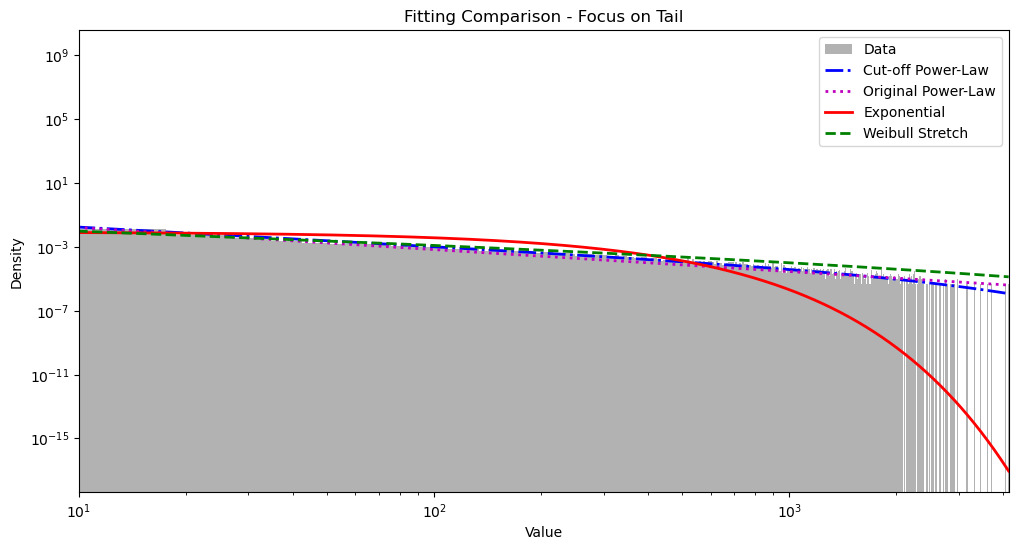

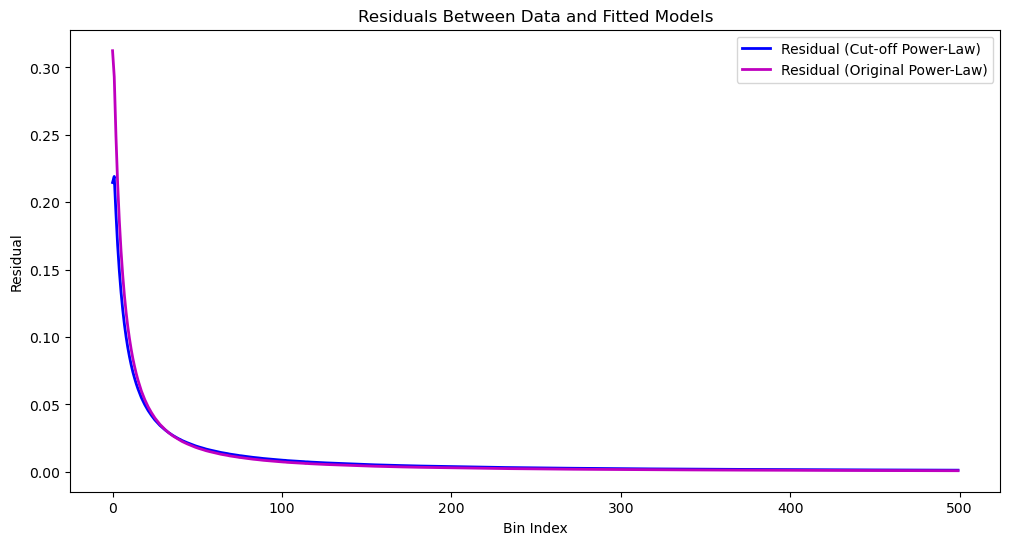

In [245]:
# Plot the main comparison, focusing on the tail region
plt.figure(figsize=(12, 6))

# Plot the histogram of data
plt.hist(w, bins=500, density=True, alpha=0.6, label='Data', color='gray')

# Plot fitted distributions
plt.plot(x[:len(pdf_cutoff)], pdf_cutoff, 'b-.', linewidth=2, label='Cut-off Power-Law')
plt.plot(x[:len(pdf_powerlaw)], pdf_powerlaw, 'm:', linewidth=2, label='Original Power-Law')
plt.plot(x, pdf_exp, 'r-', linewidth=2, label='Exponential')
plt.plot(x, pdf_weibull, 'g--', linewidth=2, label='Weibull Stretch')

# Focus on tail values
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, max(w))  # Focus on tail region

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Fitting Comparison - Focus on Tail')
plt.show()

# Plot residuals
plt.figure(figsize=(12, 6))

# Compute residuals (absolute difference between data and fitted PDFs)
residual_cutoff = np.abs(np.histogram(w, bins=500, density=True)[0] - pdf_cutoff[:500])
residual_powerlaw = np.abs(np.histogram(w, bins=500, density=True)[0] - pdf_powerlaw[:500])

# Plot residuals
plt.plot(residual_cutoff, 'b-', linewidth=2, label='Residual (Cut-off Power-Law)')
plt.plot(residual_powerlaw, 'm-', linewidth=2, label='Residual (Original Power-Law)')
plt.xlabel('Bin Index')
plt.ylabel('Residual')
plt.legend()
plt.title('Residuals Between Data and Fitted Models')
plt.show()

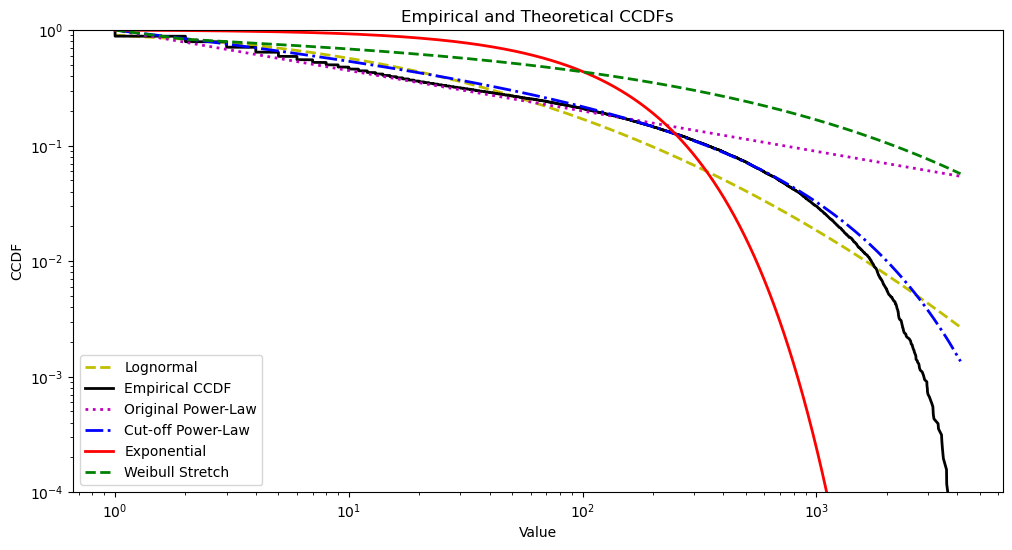

In [246]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate the empirical CCDF
sorted_data = np.sort(w)  # Sort data
ccdf_empirical = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # CCDF formula

# Step 2: Calculate the theoretical CCDFs
ccdf_powerlaw = fit.power_law.ccdf(sorted_data)  # Original power-law CCDF
ccdf_cutoff = fit.truncated_power_law.ccdf(sorted_data)  # Cut-off power-law CCDF

# Step 3: Plot the empirical and theoretical CCDFs
plt.figure(figsize=(12, 6))

# Empirical CCDF

shape, loc, scale = stats.lognorm.fit(w, floc=0)  # floc=0 constrains location
pdf_lognormal = stats.lognorm.pdf(sorted_data, shape, loc, scale)
ccdf_lognormal = 1 - stats.lognorm.cdf(sorted_data, shape, loc, scale)

# Plot
plt.plot(sorted_data, ccdf_lognormal, 'y--', label='Lognormal', linewidth=2)
plt.plot(sorted_data, ccdf_empirical, 'k-', label='Empirical CCDF', linewidth=2)

# Original Power-Law CCDF
plt.plot(sorted_data, ccdf_powerlaw, 'm:', label='Original Power-Law', linewidth=2)

# Cut-off Power-Law CCDF
plt.plot(sorted_data, ccdf_cutoff, 'b-.', label='Cut-off Power-Law', linewidth=2)

# Calculate CCDFs for Exponential and Weibull
ccdf_exponential = 1 - stats.expon.cdf(sorted_data, loc_exp, scale_exp)
ccdf_weibull = 1 - stats.weibull_min.cdf(sorted_data, shape_w, loc_w, scale_w)

plt.plot(sorted_data, ccdf_exponential, 'r-', label='Exponential', linewidth=2)
plt.plot(sorted_data, ccdf_weibull, 'g--', label='Weibull Stretch', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('CCDF')
plt.ylim(1e-4,1)
plt.legend()
plt.title('Empirical and Theoretical CCDFs')
plt.savefig('%s_won_compare.pdf'%(mode))
plt.show()

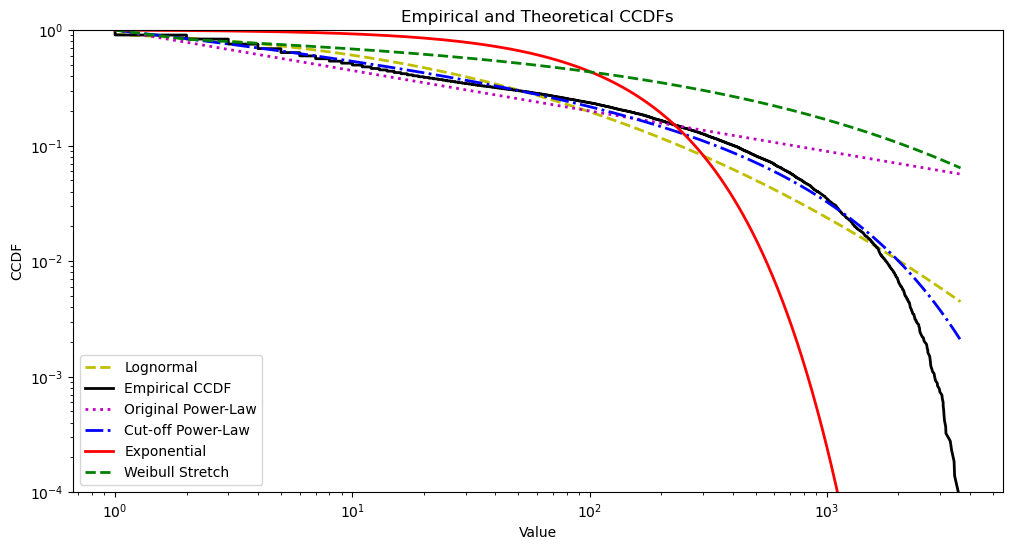

In [247]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate the empirical CCDF
sorted_data = np.sort(l)  # Sort data
ccdf_empirical = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # CCDF formula

# Step 2: Calculate the theoretical CCDFs
ccdf_powerlaw = fit.power_law.ccdf(sorted_data)  # Original power-law CCDF
ccdf_cutoff = fit.truncated_power_law.ccdf(sorted_data)  # Cut-off power-law CCDF

# Step 3: Plot the empirical and theoretical CCDFs
plt.figure(figsize=(12, 6))

# Empirical CCDF

shape, loc, scale = stats.lognorm.fit(l, floc=0)  # floc=0 constrains location
pdf_lognormal = stats.lognorm.pdf(sorted_data, shape, loc, scale)
ccdf_lognormal = 1 - stats.lognorm.cdf(sorted_data, shape, loc, scale)

# Plot
plt.plot(sorted_data, ccdf_lognormal, 'y--', label='Lognormal', linewidth=2)
plt.plot(sorted_data, ccdf_empirical, 'k-', label='Empirical CCDF', linewidth=2)

# Original Power-Law CCDF
plt.plot(sorted_data, ccdf_powerlaw, 'm:', label='Original Power-Law', linewidth=2)

# Cut-off Power-Law CCDF
plt.plot(sorted_data, ccdf_cutoff, 'b-.', label='Cut-off Power-Law', linewidth=2)

# Calculate CCDFs for Exponential and Weibull
ccdf_exponential = 1 - stats.expon.cdf(sorted_data, loc_exp, scale_exp)
ccdf_weibull = 1 - stats.weibull_min.cdf(sorted_data, shape_w, loc_w, scale_w)

plt.plot(sorted_data, ccdf_exponential, 'r-', label='Exponential', linewidth=2)
plt.plot(sorted_data, ccdf_weibull, 'g--', label='Weibull Stretch', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('CCDF')
plt.ylim(1e-4,1)
plt.legend()
plt.title('Empirical and Theoretical CCDFs')
plt.savefig('%s_lost_compare.pdf'%(mode))
plt.show()